In [1]:
import pandas as pd
import numpy as np
import scipy
import pandasql
import matplotlib.pyplot as plt

In [2]:
movie_twins = pd.read_csv("top_100_ml-latest.csv").iloc[:, 1:]
ratings = pd.read_csv("ml-latest/ratings.csv")

# Calculate Corr

In [3]:
q = '''
WITH CTE1 AS(
SELECT *
FROM ratings
JOIN movie_twins
    ON ratings.userId = movie_twins.userIdA
),
CTE2 AS(
SELECT *
FROM ratings
JOIN movie_twins
    ON ratings.userId = movie_twins.userIdB
)
SELECT CTE1.movieId, 
    CTE1.userId userId1, CTE1.rating rating1, 
    CTE2.userId userId2, CTE2.rating rating2
FROM CTE1
JOIN CTE2
    ON CTE1.movieId = CTE2.movieId
WHERE (userId1, userId2) IN (
    SELECT userIdA, userIdB
    FROM movie_twins
)
'''

res_df = pandasql.sqldf(q)
res_df

,movieId,userId1,rating1,userId2,rating2
0,34,94,4.0,81,3.0
1,34,94,4.0,81,3.0
2,34,94,4.0,81,3.0
3,34,94,4.0,81,3.0
4,34,94,4.0,81,3.0
...,...,...,...,...,...
8223,1230,584,4.0,94,4.0
8224,1230,584,4.0,94,4.0
8225,1230,584,4.0,94,4.0
8226,1230,584,4.0,94,4.0


In [6]:
correlation_data = res_df.groupby(['userId1', 'userId2']).apply(
    lambda df: df['rating1'].corr(df['rating2'])
).reset_index(name='correlation').fillna(0)

C:\Users\zhouz\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\zhouz\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [7]:
correlation_data.head()

,userId1,userId2,correlation
0,94,8,0.000000
1,94,56,0.000000
2,94,81,0.550848
3,126,81,0.000000
4,126,94,-1.000000


# Compare with rand pairs

In [8]:
num_pairs = 100
user_id1 = np.random.randint(1, 611, size=num_pairs)
user_id2 = np.random.randint(1, 611, size=num_pairs)

rand_df = pd.DataFrame({
    'userIdA': user_id1,
    'userIdB': user_id2
})

q = '''
WITH CTE1 AS(
SELECT *
FROM ratings
JOIN rand_df
    ON ratings.userId = rand_df.userIdA
),
CTE2 AS(
SELECT *
FROM ratings
JOIN rand_df
    ON ratings.userId = rand_df.userIdB
)
SELECT CTE1.movieId, 
    CTE1.userId userId1, CTE1.rating rating1, 
    CTE2.userId userId2, CTE2.rating rating2
FROM CTE1
JOIN CTE2
    ON CTE1.movieId = CTE2.movieId
WHERE (userId1, userId2) IN (
    SELECT userIdA, userIdB
    FROM rand_df
)
'''

rand_res_df = pandasql.sqldf(q)
rand_res_df

,movieId,userId1,rating1,userId2,rating2
0,6,2,4.0,403,4.0
1,6,2,4.0,403,4.0
2,11,2,3.0,403,5.0
3,11,2,3.0,403,5.0
4,34,2,5.0,403,5.0
...,...,...,...,...,...
882,318,592,5.0,68,4.5
883,4993,592,2.0,68,4.5
884,5810,592,4.0,68,4.0
885,5816,592,3.5,68,3.5


In [9]:
rand_correlation_data = rand_res_df.groupby(['userId1', 'userId2']).apply(
    lambda df: df['rating1'].corr(df['rating2'])
).reset_index(name='correlation').fillna(0)

rand_correlation_data.head()

C:\Users\zhouz\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
C:\Users\zhouz\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


,userId1,userId2,correlation
0,2,403,0.306013
1,21,597,0.990867
2,33,141,0.408248
3,51,321,0.438529
4,52,374,-1.000000


Avg Correlation from movie twins: -0.029547644802616287
Avg Correlation from random pairs: 0.08945284410049487
P-value: 0.1250339676275571
The ratings correlation between movie twins is not statistically significantly higher than random pairs at alpha = 0.05


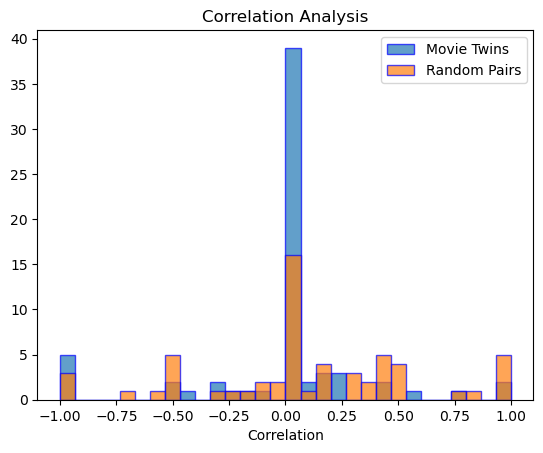

In [12]:
print(f"Avg Correlation from movie twins: {np.mean(correlation_data['correlation'])}")
print(f"Avg Correlation from random pairs: {np.mean(rand_correlation_data['correlation'])}")
print(f"P-value: {scipy.stats.ttest_ind(correlation_data['correlation'], rand_correlation_data['correlation'])[1]}")
print("The ratings correlation between movie twins is not statistically significantly higher than random pairs at alpha = 0.05")
plt.hist(correlation_data['correlation'], ec = 'b', bins = 30, alpha = 0.7, label='Movie Twins')
plt.hist(rand_correlation_data['correlation'], ec = 'b', bins = 30, alpha = 0.7, label='Random Pairs')
plt.title('Correlation Analysis')
plt.xlabel('Correlation')
plt.legend()
plt.show()